## Chinese Word Segmentation (II)--statistical method 

## However, the dictionary can not deal with ambiguity & unknown words and Maximum Matching doesn't always work. It can't measure the likelihood of a word, either.

## So we introduce another method, N-gram language model

## For unigram model, we use the frequency of a word to calculate its probability, and it means the chance of having such word is independent from context.
## If "赫尔辛基(helsinki)" [500 times] appears more than "赫尔辛基大学(University of Helsinki)"[200 times], the model will choose the former one.
## We have the probability as $P(word)=\frac{C(word)}{N}$ where N is the total word count

In [1]:
with open(r'./training and testing data/pku_training.txt',encoding='gbk') as f:# the path may need change
    content=f.readlines()
content="".join(content).strip()
#content=re.sub("。|？|！|\n","<end>",content)
content=content.split("\n")
while '  ' in content:
    content.remove('  ')
while '' in content:
    content.remove('')
for i,sentence in enumerate(content):
    content[i]=content[i].strip()
training_text='  '.join(content).split('  ')
len(training_text)

1109947

## Wait! 
##  What if the word didn't appear in the corpus at all? It doesn't necessarily mean the word is not a real word. Sometimes the corpus is just not large enough.
## We need smoothing!
## $P(word)=\frac{C(word)+1}{N+C(word_{type})}$  Laplace smoothing

In [2]:
import math
def wordcount(training_text):# count the word frequency
    count={}
    for word in training_text:
        if word in count:
            count[word]+=1
        else:
            count[word]=count.get(word,0)+1
    return count

def cal_prob(training_text):
    word_dict=wordcount(training_text)
    total_word=len(training_text)
    for i,word in enumerate(word_dict):
        word_dict[word]=-math.log((word_dict[word]+1)/(1109947+len(word_dict)))
    return word_dict

def check_prob(word,word_dict):
    if word in word_dict:
        return word_dict[word]
    else:#unseen word, add-one smoothing
        return -math.log(1/(1109947+len(word_dict)))
word_dict=cal_prob(training_text)

## Now we have probabilities and they are converted into weights. How should we find the most possible combination?

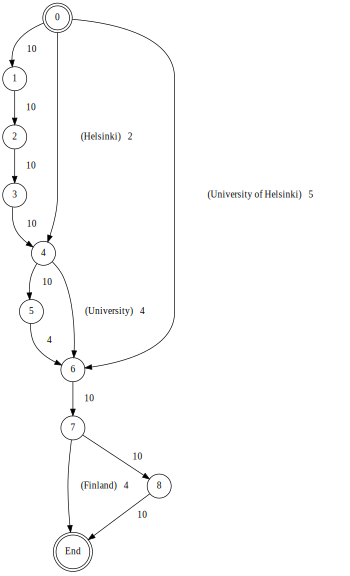

In [3]:
import graphviz
f = graphviz.Digraph()
f.attr(size='8,8')
f.attr('node', shape='doublecircle')
f.node('End')
f.node('0')
f.attr('node', shape='circle')
f.edge('0', '1',label='赫：10')
f.edge('1', '2', label='尔：10')
f.edge('2', '3',label='辛：10')
f.edge('3', '4',label='基：10')
f.edge('0', '4',label='赫尔辛基(Helsinki)：2')

f.edge('4', '5',label='大：10')
f.edge('5', '6',label='学：4')
f.edge('4', '6',label='大学(University)：4')
f.edge('0', '6',label='赫尔辛基大学(University of Helsinki)：5')
f.edge('6', '7',label='在：10')
f.edge('7', '8',label='芬：10')
f.edge('8', 'End',label='兰：10')
f.edge('7', 'End',label='芬兰(Finland)：4')
f

## Dijkstra

In [7]:
import re
def split_sentence(sentence,word_dict):
    cutpoint={}
    l=len(sentence)
    #'''
    #add regular expression
    time_pattern="([0-9零一二三四五六七八九十o○.]{2,}[年月日点时分秒%]*)"
    time_list=re.findall("([0-9零一二三四五六七八九十o○.]{2,}[年月日点时分秒%]*)",sentence)
    sentence=re.sub(time_pattern,"T",sentence)
    #add regular expression
    #'''
    for i in range(l):#generating directed acyclic graph
        cutpoint[i]=[]
        for j in range(i,l):
            if sentence[i:j+1] in word_dict:
                cutpoint[i].append(j)
        if cutpoint[i]==[]:
            cutpoint[i].append(i)
            
    #search for shortest path for word network, Dijkstra
    dist_matrix=np.full((l,l),math.inf)#creating adjacency matrix
    for i in cutpoint:
        for j in cutpoint[i]:#defining weight with prob
            dist_matrix[i][j],dist_matrix[j][i]=check_prob(sentence[i:j+1],word_dict),check_prob(sentence[i:j+1],word_dict)# didn't solve for OOV, add regex
    prenode=dict.fromkeys(range(l), 0)#initialize prenode
    #prenode will be like: {0:0,1:0,2:0,3:0...}
    lowest_cost=[] 
    for i in cutpoint:
        lowest_cost.append(dist_matrix[0][i])#store the lowest weight from 0 to i(current node)
        for j in range(0,i):
            if lowest_cost[i]>lowest_cost[j]+dist_matrix[j+1][i]:#if prenode enables shorter path, record prenode
                prenode[i]=j+1
                lowest_cost[i]=lowest_cost[j]+dist_matrix[j+1][i]#refresh value of lowest_cost
    
    #split sentence according to word nodes
    end=l-1;split=[]
    result=[]
    while end > -1 :
        split.append((prenode[end],end))
        end=prenode[end]-1
    for nodes in split[::-1]:
        result.append(sentence[nodes[0]:nodes[1]+1])
    #'''
    #add regular expression    
    result='  '.join(result)
    for i in range(len(time_list)):
        result=result.replace("T",time_list[0],1)
        time_list.pop(0)
    #add regular expression
    #'''
    result=''.join(result)# if regular expression function is turned off, result should be '  '.join(result)
    return result
split_sentence("共同创造美好的新世纪——二○○一年新年贺词",word_dict)

'共同  创造  美好  的  新世纪  ——  二○○一年  新年  贺词'

In [8]:
with open(r'./training_and_testing_data/pku_test.txt',encoding='gbk') as f:# the path may need change
    test=f.readlines()
for i,s in enumerate(test):
    test[i]=split_sentence(s,word_dict)

In [10]:
with open('pku_test_segmentation_u_r.txt',"a") as f:
    f.writelines(test)

In [34]:
a='共同创造美好的新世纪——二○○一年新年贺词79.5%'
time_pattern="([0-9一二三四五六七八九十o○.]+[年月日点时分秒%]*)"
time_=re.findall("([0-9一二三四五六七八九十o○.]+[年月日点时分秒%]*)",a)
s=re.sub(time_pattern,"T",a)
print(s)
print(time_)

共同创造美好的新世纪——T新年贺词T
['二○○一年', '79.5%']


In [24]:
split_sentence("这几天天天天气都很好",word_dict) # Everyday's weather is good in recent days

'这  几  天  天天  天气  都  很  好'